 Hypothesis: facendo un fit con una finestra di n giorni (e.g. 100 giorni), l'algoritmo è in grado di trovare gli shocks che durano circa il 5%-15% della finestra (e.g. 5-15 giorni)

In [1]:
import inspect
import pystable
inspect.getfile(pystable)

ModuleNotFoundError: No module named 'pystable'

In [11]:
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import pystable
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import datetime
from typing import List


pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams["figure.figsize"] = (20,15)

FREQS = {
    "1m": "1T",
    "5m": "5T",
    "30m": "30T",
    "1h": "60T",
    "12h": "720T",
    "1d": "1440T",
    "5d": "7200T",
    "10d": "14400T"
}

init_fit = {"alpha": 2, "beta": 0, "sigma": 1, "mu": 0, "parameterization": 1}
dist = pystable.create(
    init_fit["alpha"],
    init_fit["beta"],
    init_fit["sigma"],
    init_fit["mu"],
    init_fit["parameterization"],
)

### BTC/USD

In [12]:
def resample(df: pd.DataFrame, freq, mode="last"):
    ohlc_dict = {                                                                                                                                                                                                                  
        'close': 'mean',  
    }
    return df.resample(freq, closed='left', label='left').apply(ohlc_dict).dropna()

def filter_df(df, start_date, end_date):
    mask = (df.index > start_date) & (df.index < end_date)
    return df.loc[mask]

def to_human_time(unix_time):
    t = datetime.datetime.utcfromtimestamp(unix_time)
    return { 
        "datetime": f"{t.year}-{t.month}-{t.day} {t.hour}:{t.minute}",
        "date": f"{t.year}-{t.month}-{t.day}",
        "time": f"{t.hour}:{t.minute}",
        "year": t.year,
        "month": t.month,
        "day": t.day,
        "hour": t.hour,
        "minute": t.minute
    }

def load(data_path, date="Timestamp"):
    df = pd.read_csv(data_path)
    if date=="Timestamp":
        df["datetime"] = df["Timestamp"].apply(lambda t: to_human_time(t)["datetime"])
    else:
        df["datetime"] = df[date]
    return df

def preprocess(df):
    if "Adj Close" in df.keys():
        close = "Adj Close"
    elif "close" in df.keys():
        close = "close"
    elif "Close" in df.keys():
        close = "Close"
    df.index = pd.to_datetime(df["datetime"])  
    df["close"] = df[close].ffill()
    return df[["close"]]

def fit_levy(dist, log_returns, return_param="alpha"):
    pystable.fit(dist, log_returns, len(log_returns))
    if return_param=="alpha":
        return dist.contents.alpha
    if return_param=="beta":
        return dist.contents.beta
    if return_param=="sigma":
        return dist.contents.sigma
    if return_param=="mu":
        return dist.contents.mu
        
# data = preprocess(load("/home/ema/dev/stock-shocks/shocks/data/NASDAQ.csv", date="Date"))
# data = data.loc[data.index < "1996-01"]

# data = preprocess(load("/home/ema/dev/stock-shocks/shocks/data/BRK-B.csv", date="Date"))
# data = data.loc[data.index <= "2005-01"]

data_path = "/home/ema/dev/shocks/data/old/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv"
data = preprocess(load(data_path))
#data = data.loc[data.index > "2012-03"]


In [1]:
import pickle
with open("/home/ema/dev/shocks/data/processed/BNBBTC_5m.pkl", "rb") as f:
    proc = pickle.load(f)

In [177]:
from matplotlib.finance import candlestick2_ohlc
df = pd.read_csv("/home/ema/dev/shocks/data/binance/BNBBTC/BNBBTC-1m-2021-04.zip")
df.columns = ["Open time", "Open", "High", "Low", "Close", "Volume", "Close time", "Quote asset volume", "Number of trades", "Taker buy base asset volume", "Taker buy quote asset volume", "Ignore"]
df

ModuleNotFoundError: No module named 'matplotlib.finance'

0.6979351913905787


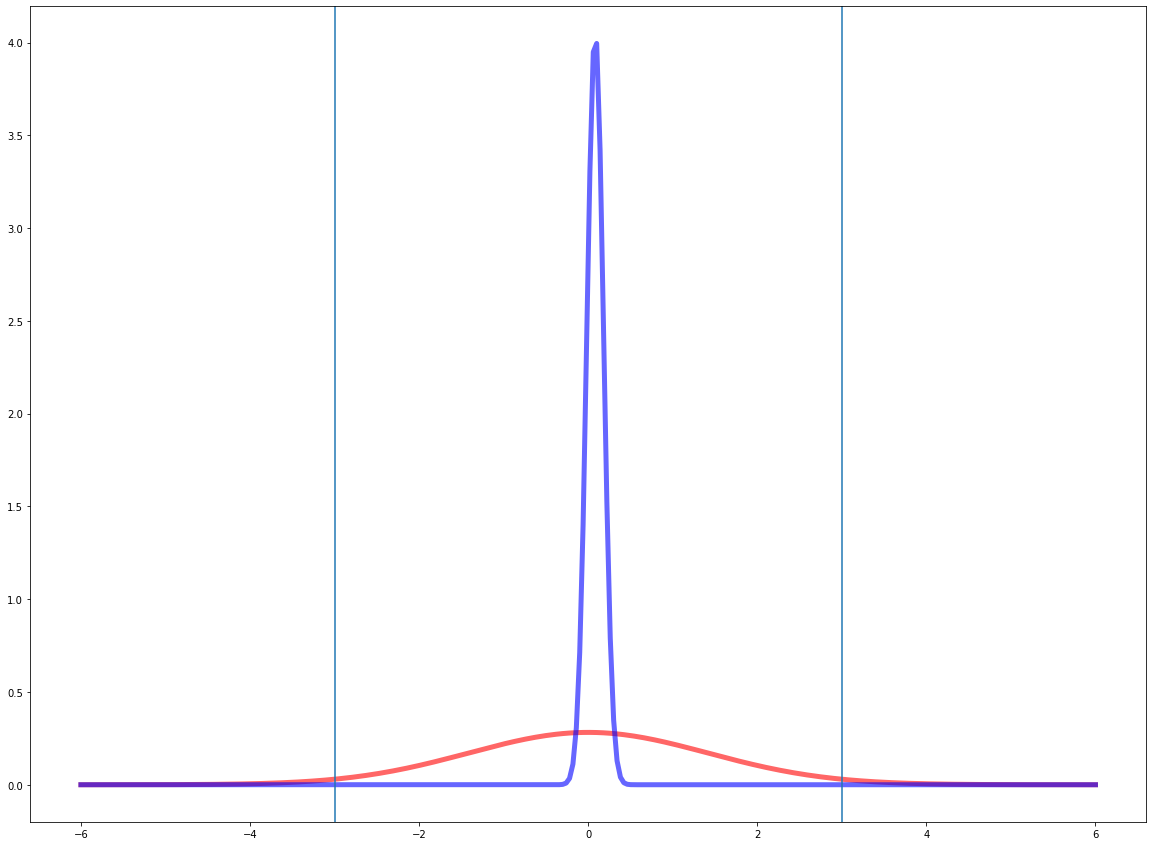

In [72]:
from scipy.stats import levy_stable, norm
from scipy.spatial.distance import jensenshannon
fig, ax = plt.subplots(1, 1)


levy = levy_stable(alpha=2, beta=0)



alpha, beta = 2, 0

mean, var, skew, kurt = levy_stable.stats(alpha, beta, moments='mvsk')
x = np.linspace(start=-6,stop=6, num=300)
l = levy_stable.pdf(x, alpha, beta)

gauss = norm(*norm.fit(l))
g = gauss.pdf(x)
js = jensenshannon(g, l)
print(js)
ax.plot(x, l, 'r-', lw=5, alpha=0.6, label='levy_stable pdf')
ax.plot(x, g, 'b-', lw=5, alpha=0.6, label='normal pdf')
ax.axvline(3)
ax.axvline(-3)
plt.show()

0.5 0.22110458676965467
1 0.16713056824968847
1.5 0.16230329818542494
2 0.1616020904545621


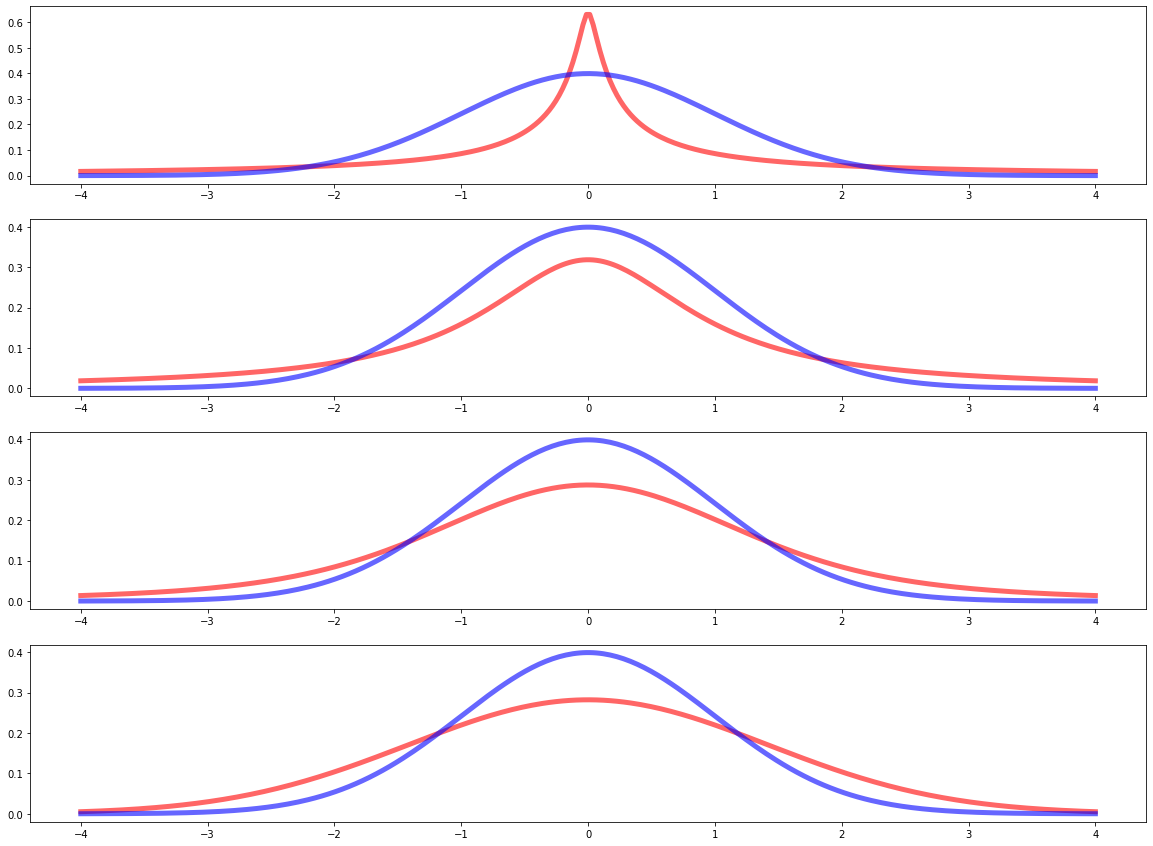

In [88]:
q = levy_stable.ppf(0.90, alpha, beta)
x = np.linspace(start=-4,stop=4, num=300)
gauss = norm()
g = gauss.pdf(x)

alphas = (0.5, 1, 1.5, 2)

fig, ax = plt.subplots(len(alphas), 1)

for idx, alpha in enumerate(alphas):
    mean, var, skew, kurt = levy_stable.stats(alpha, 0, moments='mvsk')
    l = levy_stable.pdf(x, alpha, 0)
    js = jensenshannon(g, l)
    print(alpha, js)
    ax[idx].plot(x, l, 'r-', lw=5, alpha=0.6, label='levy_stable pdf')
    ax[idx].plot(x, g, 'b-', lw=5, alpha=0.6, label='normal pdf')
plt.show()

In [87]:
levy_stable(0.1, 0).cdf(3), norm().cdf(3)

(0.7144593014636031, 0.9986501019683699)

In [ ]:
# df, shocks = find_shocks(data, std_from_mean=3.5, resample_freq="1d", plot=False, start_date="2014", end_date="2017")
df = fit(data, start_date="2014", end_date="2017", window =  len(data) - 1)

init_fit = {'alpha': 2, 'beta': 0, 'sigma': 1, 'mu': 0, 'parameterization': 1}
dist = pystable.create(init_fit['alpha'], init_fit['beta'],
                    init_fit['sigma'], init_fit['mu'],
                    init_fit['parameterization'])
                    

pystable.fit(dist, df["returns"], len(df["returns"]))
pystable.cdf(dist, )

In [ ]:
ma = d.rolling(window=25).mean()
b_up =  ma + 2 * d.rolling(25).std() 
b_down =  ma - 2 * d.rolling(25).std() 

plt.plot(d, label="price")
plt.plot(ma, label="ma", color="red", alpha=0.7)
plt.plot(b_up, color="green", alpha=0.7)
plt.plot(b_down, color="green", alpha=0.7)
plt.legend(prop={"size": 20})
plt.ylabel("Price ($)")
plt.xlabel("Time")

In [ ]:
d = load("/home/ema/dev/shocks/data/old/AAPL.csv", "Date")
d = filter_df(preprocess(d), "2010-01", "2012-04") 
ewm = d.ewm(span=25).mean()
ma = d.rolling(window=25).mean()
plt.plot(d, label="price")
plt.plot(ewm, label="EMA", color="red")
plt.legend(prop={"size": 20})
plt.ylabel("Price ($)")
plt.xlabel("Time")

In [ ]:
d = filter_df(data, "2015-01", "2016-04")
plt.plot(d['close'].pct_change().dropna())
plt.ylabel("returns ($)")
plt.xlabel("Time")

In [92]:
def _plot(df, shocks=None, savename=None, threshold=None):
    fig, axs = plt.subplots(len(df.columns))
   # fig.suptitle('BTC/USD')
    df = df.dropna()
    for idx, key in enumerate(df.columns):
        axs[idx].plot(df[key])
        axs[idx].set_title(key)
        axs[idx].grid(True)
        if key in ["Close", "close"]:
            key = "Price ($)"
        axs[idx].set_ylabel(key)
        if key == "returns" and threshold is not None:
            upper, lower = compute_shock(df[key],threshold)
            axs[idx].axhline(upper, alpha= 1, color="black")
            axs[idx].axhline(lower, alpha= 1, color="black")

        if shocks is not None:
            #trans = axs.get_xaxis_transform()
            for i, shock in enumerate(shocks):
                axs[idx].axvline(df.index[shock], alpha=0.5, color="red")
               # axs[idx].axvline(shock["end"], alpha=0.5, color="red")
                label_position = 0.32 if i%2 == 0 else -0.5
                plt.text(df.index[shock], label_position, df.index[shock], fontdict={"color": "red"})
    plt.xlabel("Time")
    
    if savename is not None:
        plt.savefig(savename)
    plt.show()


def compute_shock(returns, threshold):
    upper = returns.mean() + threshold * returns.std()
    lower = returns.mean() - threshold * returns.std()
    return upper, lower

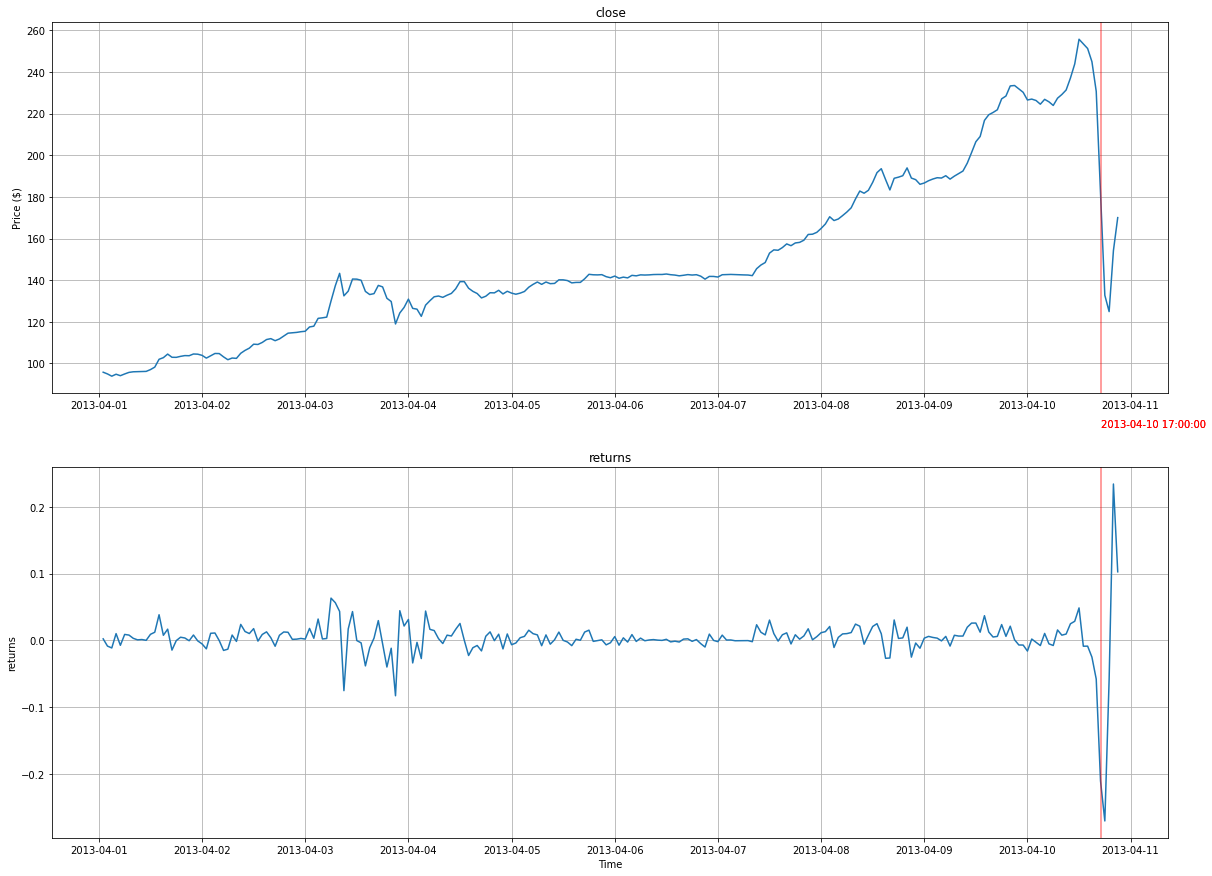

In [95]:
d = filter_df(data, start_date="2013-04", end_date="2013-04-10 22:00")
d = resample(d, freq="1h")
d["returns"] = d['close'].pct_change().dropna()
shock_idx = 0.5 * (d["returns"].argmax() + d["close"].argmax())
_plot(d, shocks=[int(shock_idx)])


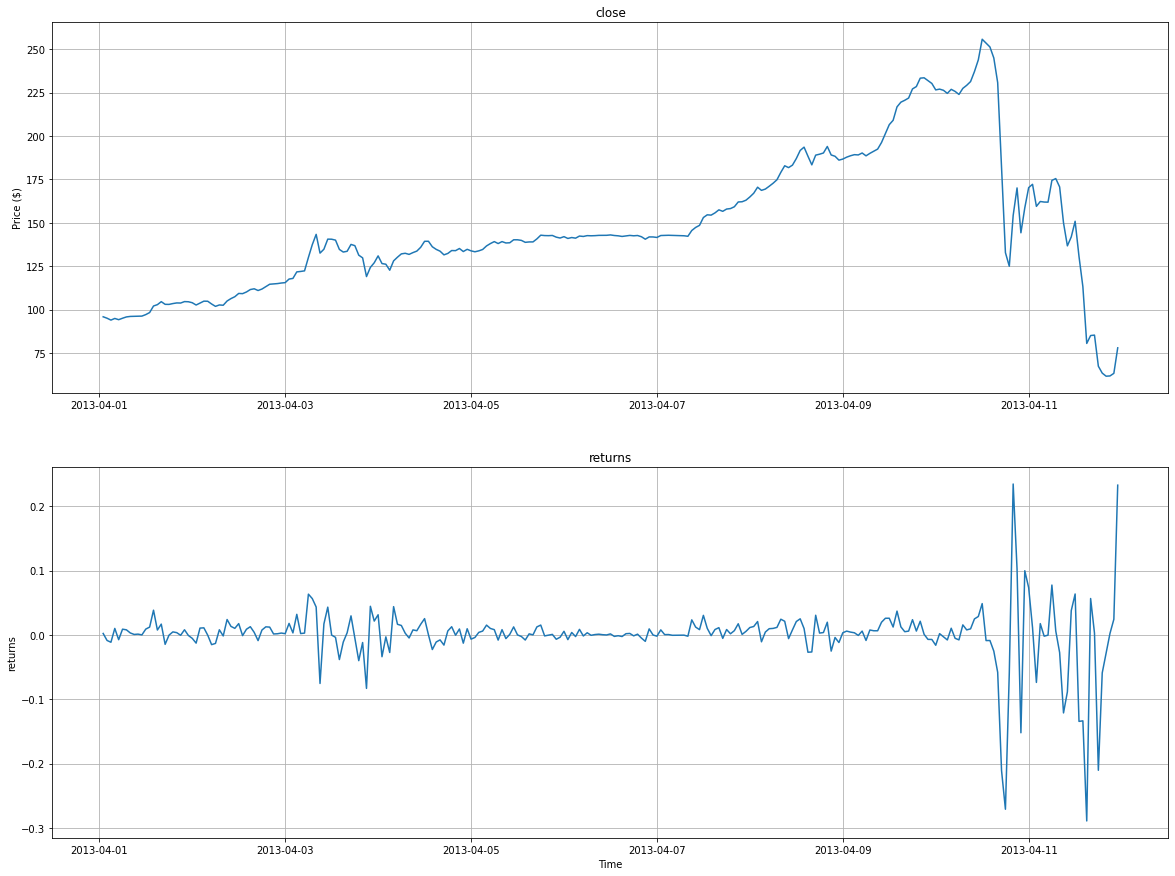

([1.577, 98.868, 97.199], [0.0, 100.0, 99.052])

In [164]:
# df, shocks = find_shocks(data, std_from_mean=3.5, resample_freq="1d", plot=False, start_date="2014", end_date="2017")
d = filter_df(data, start_date="2013-04", end_date="2013-04-12")
d = resample(d, freq="1h")
d["returns"] = d['close'].pct_change().dropna()

_plot(d)

init_fit = {'alpha': 2, 'beta': 0, 'sigma': 1, 'mu': 0, 'parameterization': 1}
dist = pystable.create(init_fit['alpha'], init_fit['beta'],
                    init_fit['sigma'], init_fit['mu'],
                    init_fit['parameterization'])
                    
vals = [el for el in [-0.2, 0.2, 0.08]]
pystable.fit(dist, d["returns"].dropna(), len(d["returns"].dropna()))
[np.round(el * 100, 3) for el in pystable.cdf(dist, vals, len(vals))], [np.round(el * 100, 3) for el in normal.cdf(vals)]

In [159]:
pystable.q(dist, [0.25], 1)
normal = norm(*norm.fit(d["returns"].dropna()))
[np.round(el * 100, 3) for el in normal.cdf(vals)]

[0.0, 100.0, 99.844]

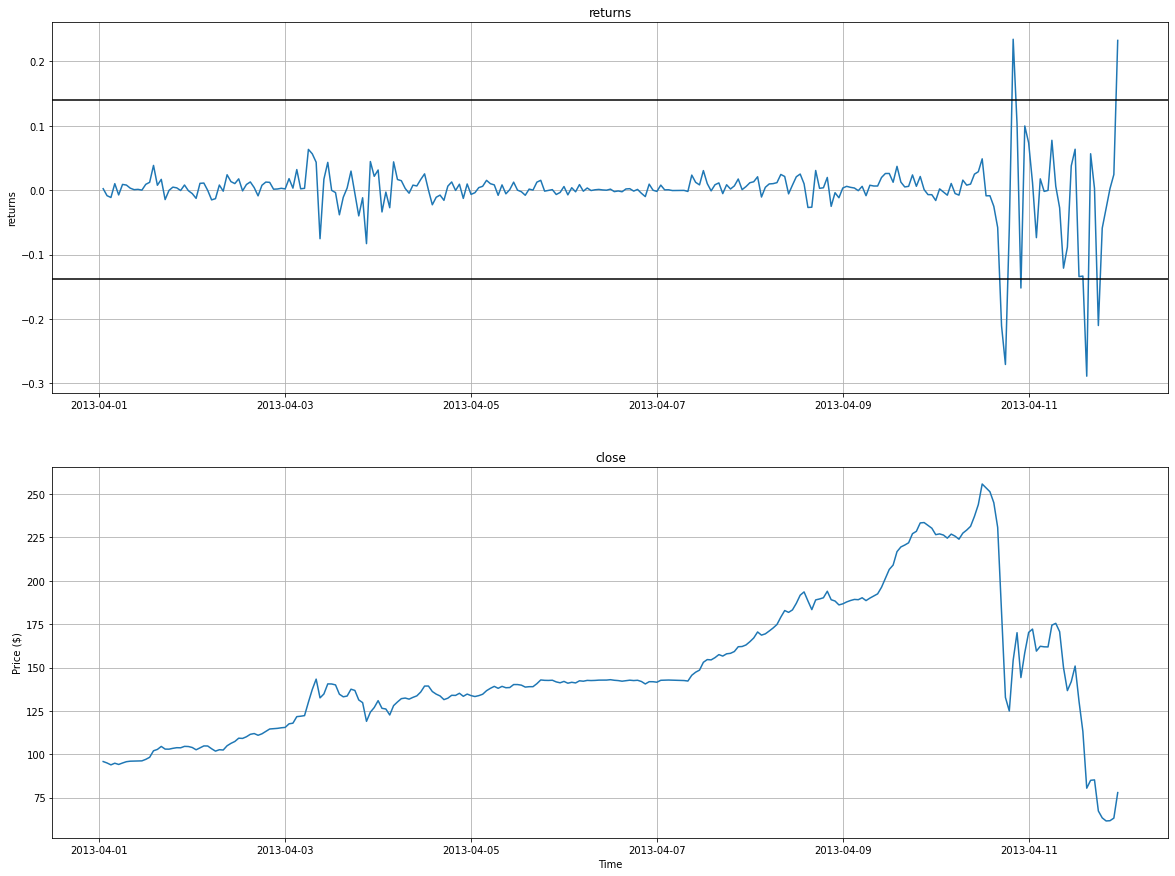

In [165]:
_plot(d[["returns", "close"]], threshold=3)

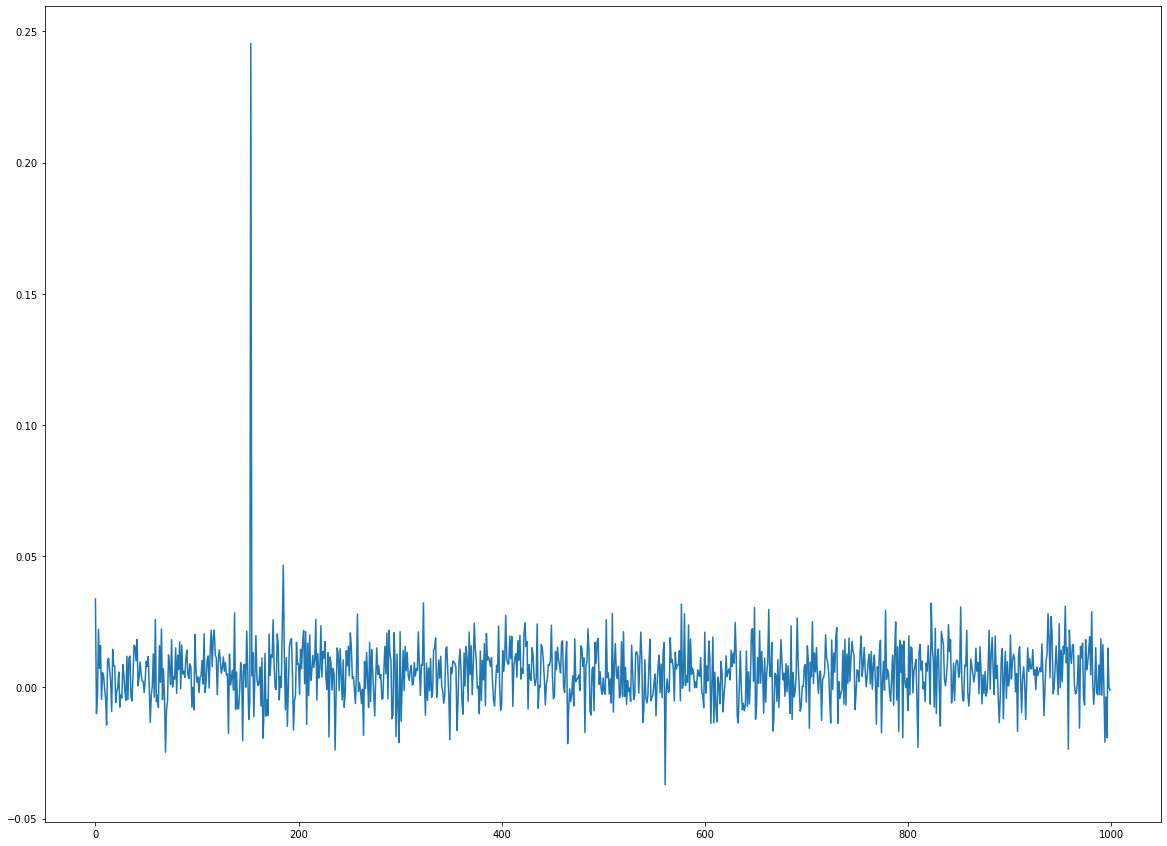

In [128]:
d = pystable.rnd(dist, seed=0, n=1000)
plt.plot([el/10 for el in d])

#### fitting

In [169]:
a = norm()
a.cdf(4)

0.9999683287581669

In [90]:
def fit(df, resample_freq="1d", window=100, start_date = "2012-01-01", end_date="2016-01-01", preprocess=True, do_resample=True):
    if preprocess:
        if resample_freq not in FREQS:
            raise ValueError(f"resample frequency should be one of {list(FREQS.keys())}")
        if do_resample:
            df = resample(df, FREQS[resample_freq])
    
        df = filter_df(df, start_date, end_date)

    # daily returns
    df["returns"] = df['close'].pct_change().dropna()

    # log returns: shift 1 for as ascending, -1 for descending
    df["log_returns"] = np.log(df['close']/df['close'].shift(1)).dropna()


    init_fit = {'alpha': 2, 'beta': 0, 'sigma': 1, 'mu': 0, 'parameterization': 1}
    dist = pystable.create(init_fit['alpha'], init_fit['beta'],
                        init_fit['sigma'], init_fit['mu'],
                        init_fit['parameterization'])

    df["alpha"] = df["log_returns"].rolling(window).apply(lambda window: fit_levy(dist, window, "alpha")) # window days
    df["beta"] = df["log_returns"].rolling(window).apply(lambda window: fit_levy(dist, window, "beta"))
    return df


def plot(df, shocks=None):
    fig, axs = plt.subplots(4)
    fig.suptitle('BTC/USD')
    df = df.dropna()
    for idx, key in enumerate("returns close alpha beta".split()):
        axs[idx].plot(df[key])
        axs[idx].set_title(key)
        axs[idx].grid(True)
    
        if shocks is not None:
            #trans = axs.get_xaxis_transform()
            for i, shock in enumerate(shocks):
                axs[idx].axvline(shock["start"], alpha=0.5, color="red")
                axs[idx].axvline(shock["end"], alpha=0.5, color="red")
                label_position = 0.5 if i%2 == 0 else -0.5
                plt.text(shock["start"], label_position, shock["duration"])
    plt.show()
            

In [91]:
# df, shocks = find_shocks(data, std_from_mean=3.5, resample_freq="1d", plot=False, start_date="2014", end_date="2017")
df = fit(data, start_date="2014", end_date="2017", window =  len(data) - 1)

init_fit = {'alpha': 2, 'beta': 0, 'sigma': 1, 'mu': 0, 'parameterization': 1}
dist = pystable.create(init_fit['alpha'], init_fit['beta'],
                    init_fit['sigma'], init_fit['mu'],
                    init_fit['parameterization'])
                    

pystable.fit(dist, df["returns"], len(df["returns"]))
dist.contents.alpha

1.240994467607648

In [100]:
df["returns"].dropna().mean()

0.0005938573304159057

In [63]:
from scipy.stats import levy_stable
levy = levy_stable(alpha=alpha, beta=beta)
levy.cdf(15)

0.9901167189038765

In [115]:
x = [-0.17912070153803983, 0.1673333856921102, 0.0004405]
[100 * el for el in pystable.cdf(dist, x, len(x))]

[0.7341628649594204, 99.1108817432788, 50.000272596846585]

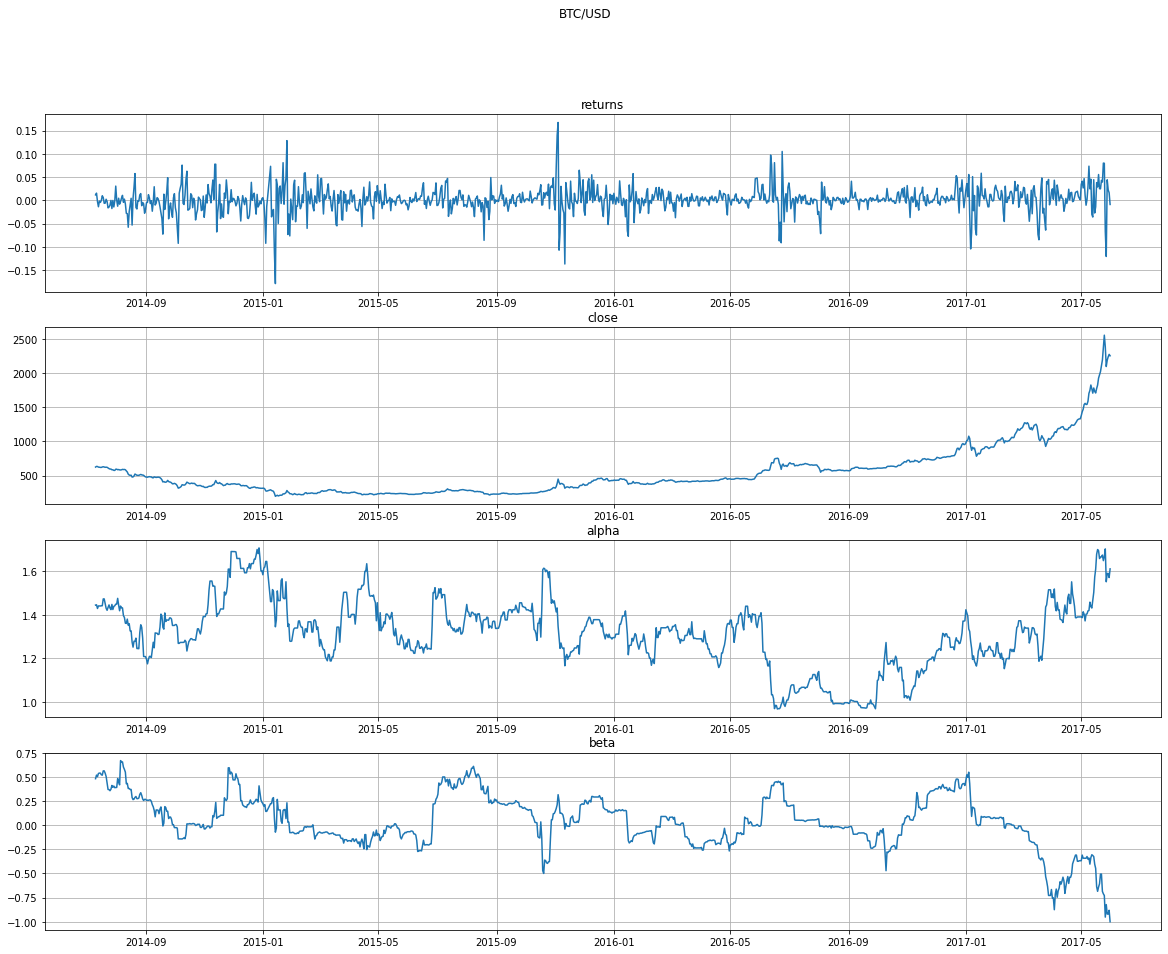

In [86]:
resample_freq = "1d"

df = fit(data, start_date="2014-04", end_date="2017-06-01", resample_freq=resample_freq, window=100)
plot(df.dropna())

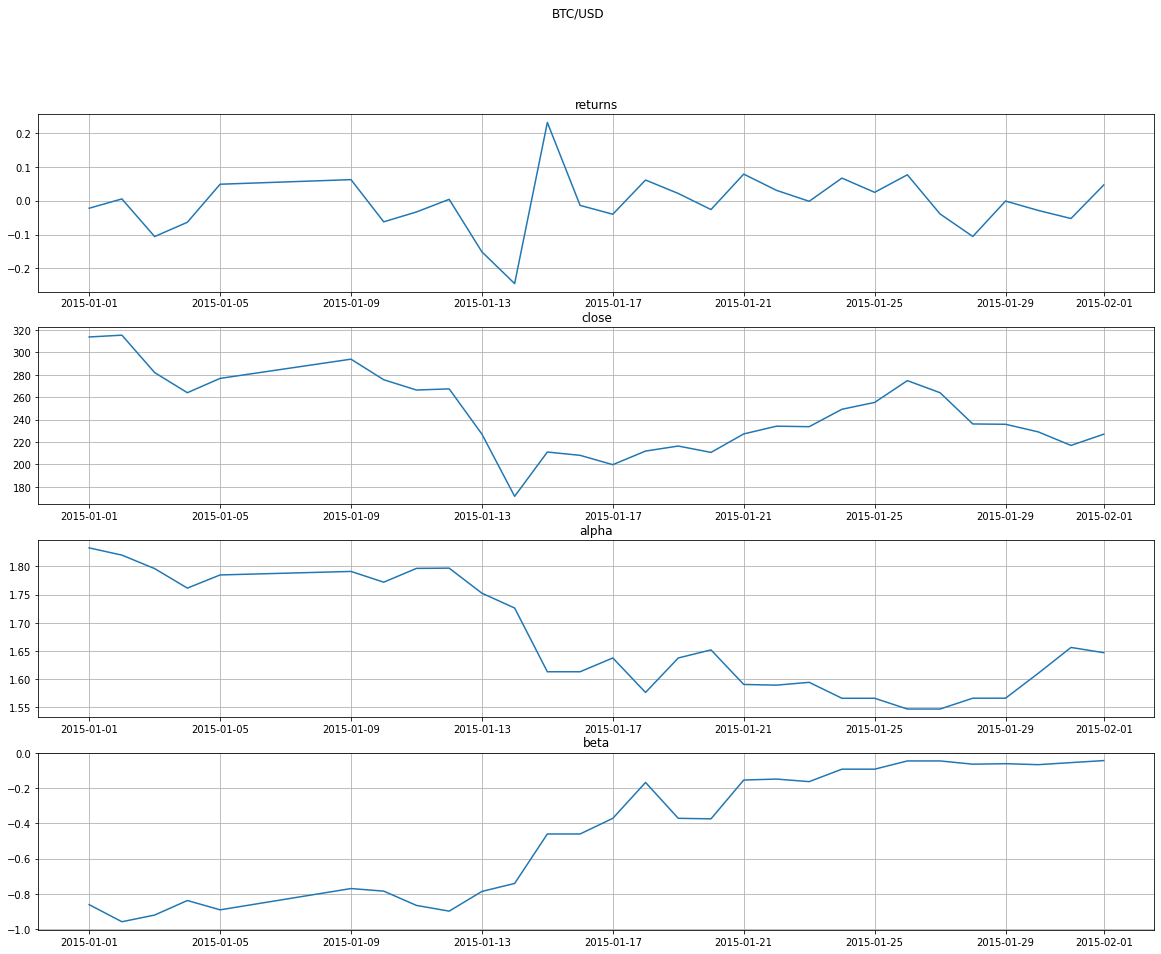

In [156]:
mask = (df.index >= "2015-01") & (df.index <= "2015-02")

plot(df.loc[mask].dropna())

/home/ema/.cache/pypoetry/virtualenvs/shocks-FMWpa96A-py3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


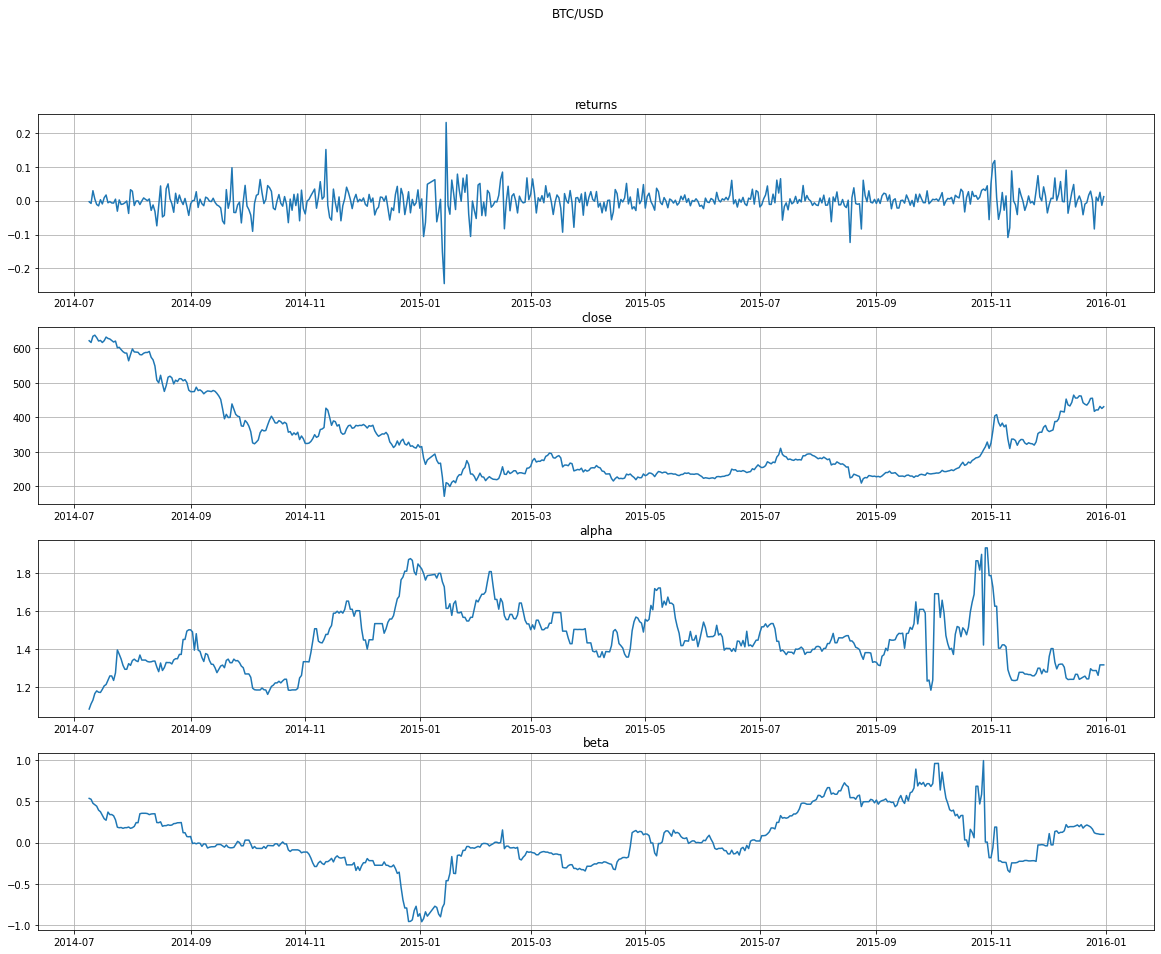

In [134]:
resample_freq = "1d"
#shocks = create_shock(data, resample_freq=resample_freq, duration=10, n_shocks=1)
df = fit(shocks, resample_freq=resample_freq, window=100)
plot(df.dropna())



FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success


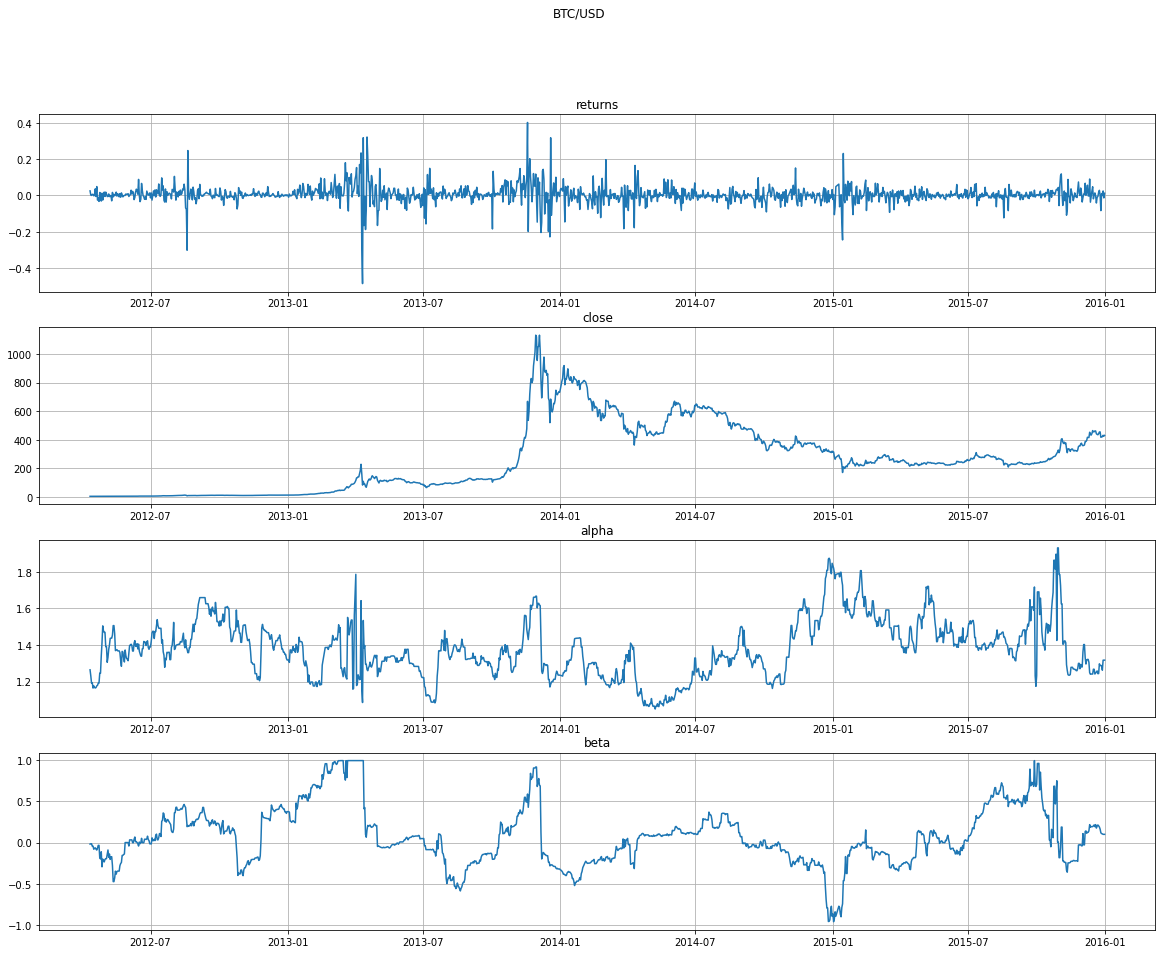

In [27]:
# window 100, freq "1d" leads to good results
# window 50, freq 1d is bad. probably not enough observations

df = fit(data, resample_freq="1d", window=100)
plot(df.dropna())

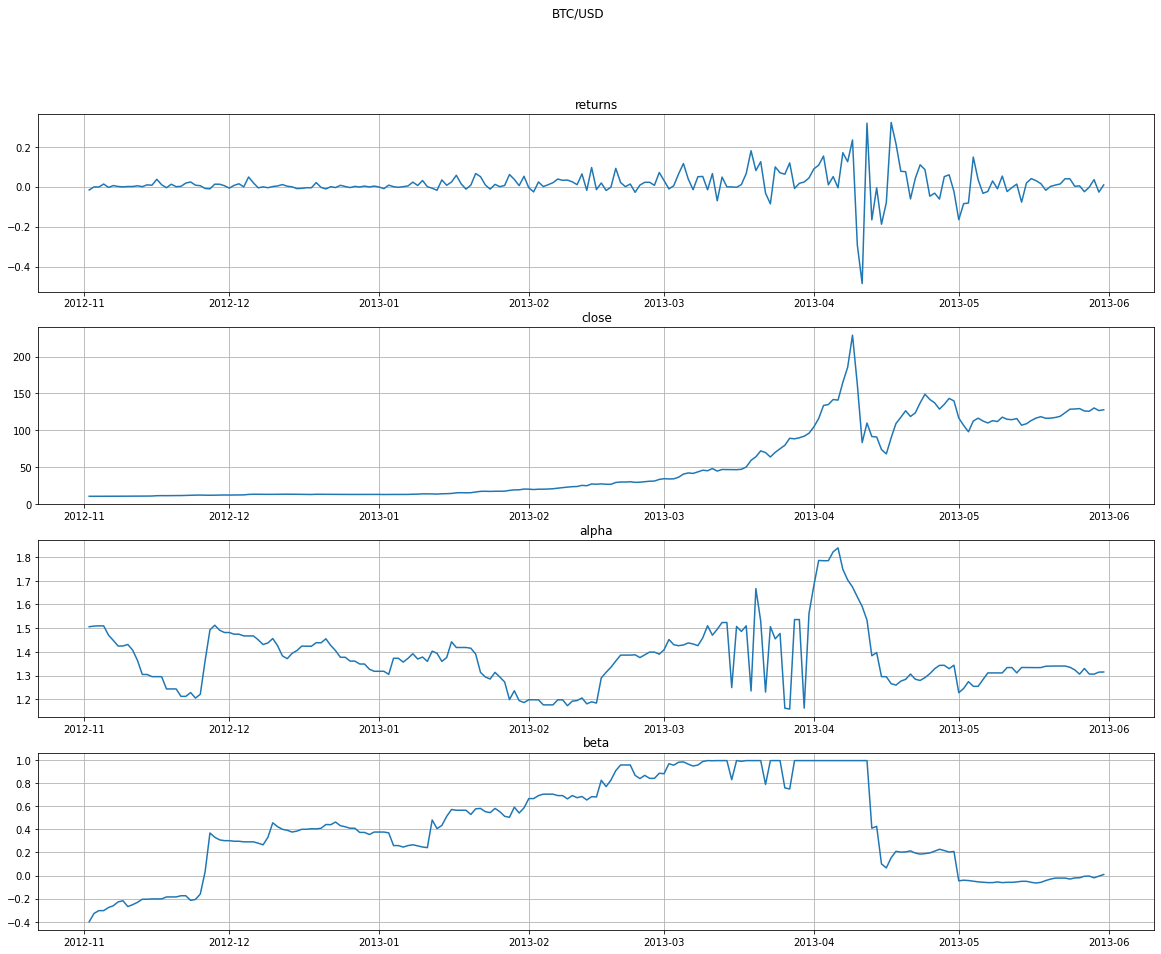

In [68]:

df = fit(data, resample_freq="1d", window=100, start_date="2010-01", end_date="2014-01")

start_date="2012-11-01"
end_date="2013-06-01"
plot(filter(df.dropna(), start_date=start_date, end_date=end_date))

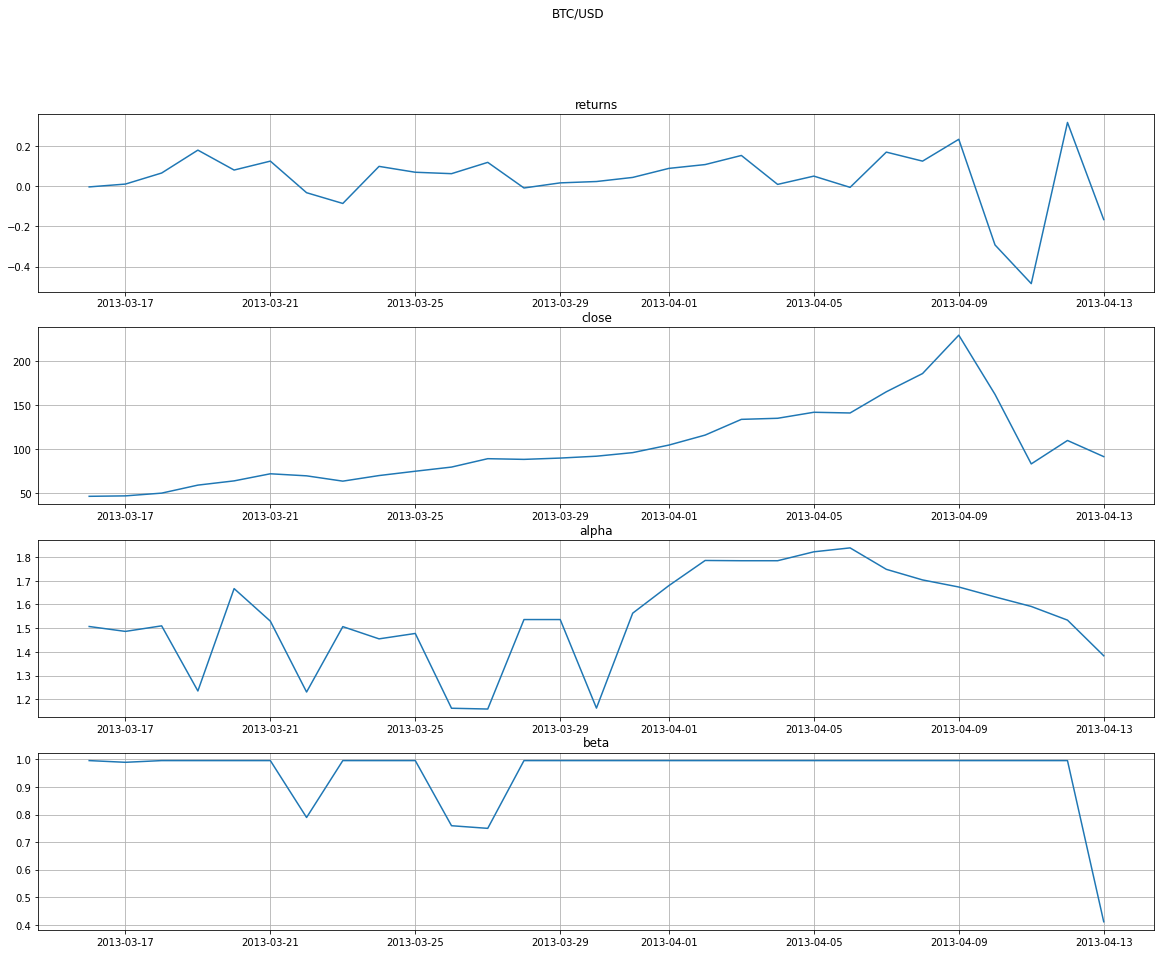

In [72]:
start_date="2013-03-15"
end_date="2013-04-14"
plot(filter(df.dropna(), start_date=start_date, end_date=end_date))

# the shock start where it drops ?
# let's say the shock lasted 10 days: from 3/4 to 13/4

In [57]:
import pickle
with open("./shocks/data/BTCUSDT_hourly_10_days_alpha.pkl", "rb") as f:
    df = pickle.load(f)["dataframe"]
# with open("./shocks/data/BTCUSDT_hourly_10_days_alpha.pkl", "wb") as f:

#     pickle.dump({
#         "dataframe": df,
#         "description": "BTCUSDT resampled on an hourly period. Levy distribution is fit on a window of 10 days (600 hours) with a step of 1h"
#     }, f)

#### baseline: controlled shock

In [34]:
def find_shocks(df: pd.DataFrame, start_date="2014", end_date="2017", resample_freq="1d", std_from_mean: int=4,  min_duration=3, max_duration=15, plot: bool=False) -> dict:
    if resample_freq not in FREQS:
        raise ValueError(f"resample frequency should be one of {list(FREQS.keys())}")

    # slice and resample
    mask = (df.index >= start_date) & (df.index <= end_date)
    df = resample(df.loc[mask], FREQS[resample_freq])

    # find dates where returns distribution in more than std_from_mean away from mean
    df["returns"] = df['close'].pct_change().dropna()
    threshold = df["returns"].mean() + std_from_mean * df["returns"].std()
    shocks = df["returns"][(df["returns"].apply(abs) >= threshold)]

    # shocks is just a list of dates, we need to extract the individual shocks from there
    shocks_dates = []
    start = shocks.index[0]
    for i in range(len(shocks.index)-1):
        next_start = shocks.index[i+1]
        end = shocks.index[i]
        if len(df.loc[start : next_start]) >= max_duration:
            shocks_dates.append({"start": start, "end": end, "duration": end-start})
            start = next_start

    shocks_dates.append({"start": start, "end": shocks.index[-1], "duration": shocks.index[-1]-start})

    shocks_dates = [el for el in shocks_dates if len(df.loc[el["start"] : el["end"]]) >= min_duration]
    if plot:
        fig, axs = plt.subplots(2)
        fig.suptitle('BTC/USD')

        for idx, key in enumerate("close returns".split()):
            axs[idx].plot(df[key])
            axs[idx].set_title(key)
            axs[idx].grid(True)
            if key == "returns":
                axs[idx].axhline(threshold, color="black")
                axs[idx].axhline(-threshold, color="black")
            for i in shocks.index:
                axs[idx].axvline(i, alpha=0.5, color="red")

    return df, shocks_dates
    

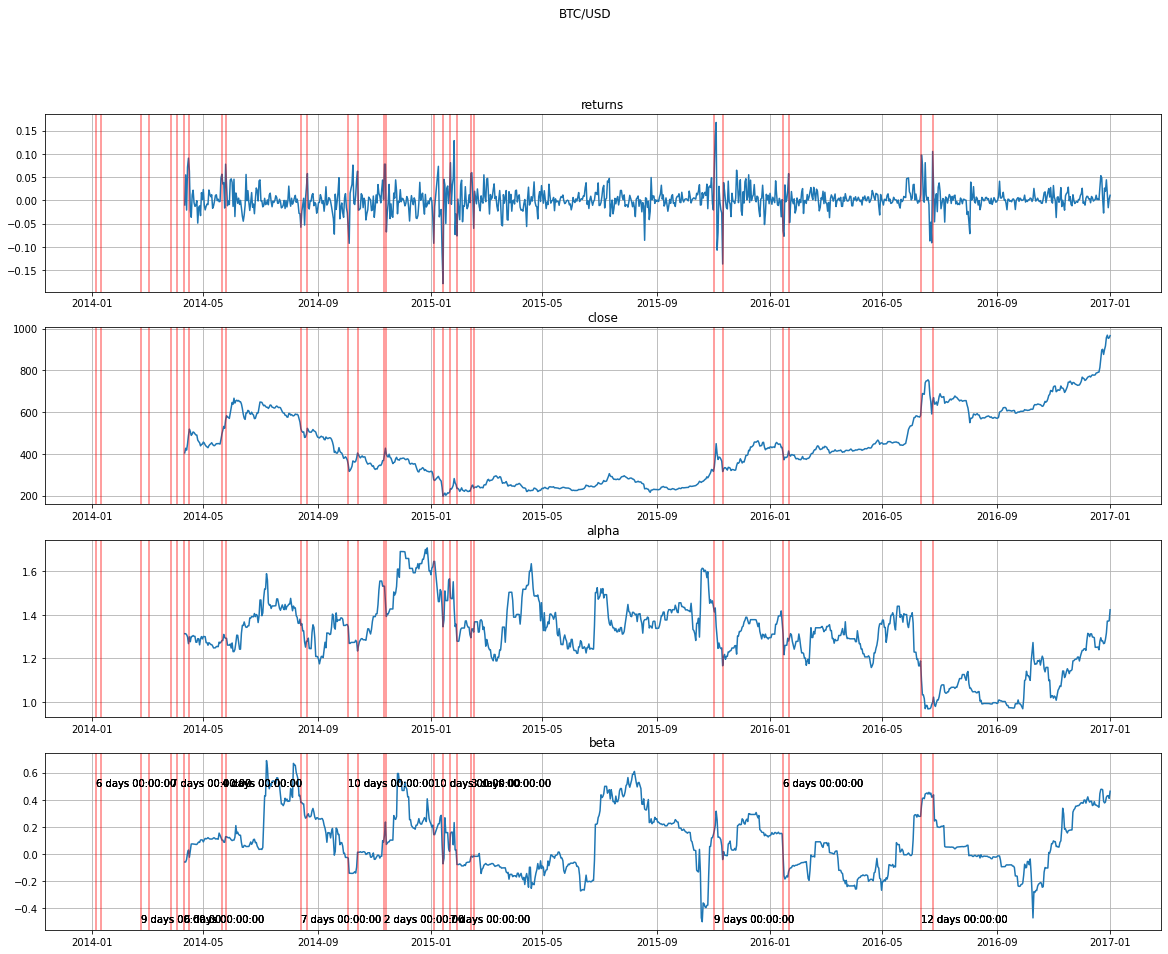

In [15]:
df, shocks = find_shocks(data, std_from_mean=2, resample_freq="1d", plot=False, start_date="2014", end_date="2017")
fitted = fit(df, preprocess=False)
plot(fitted, shocks)

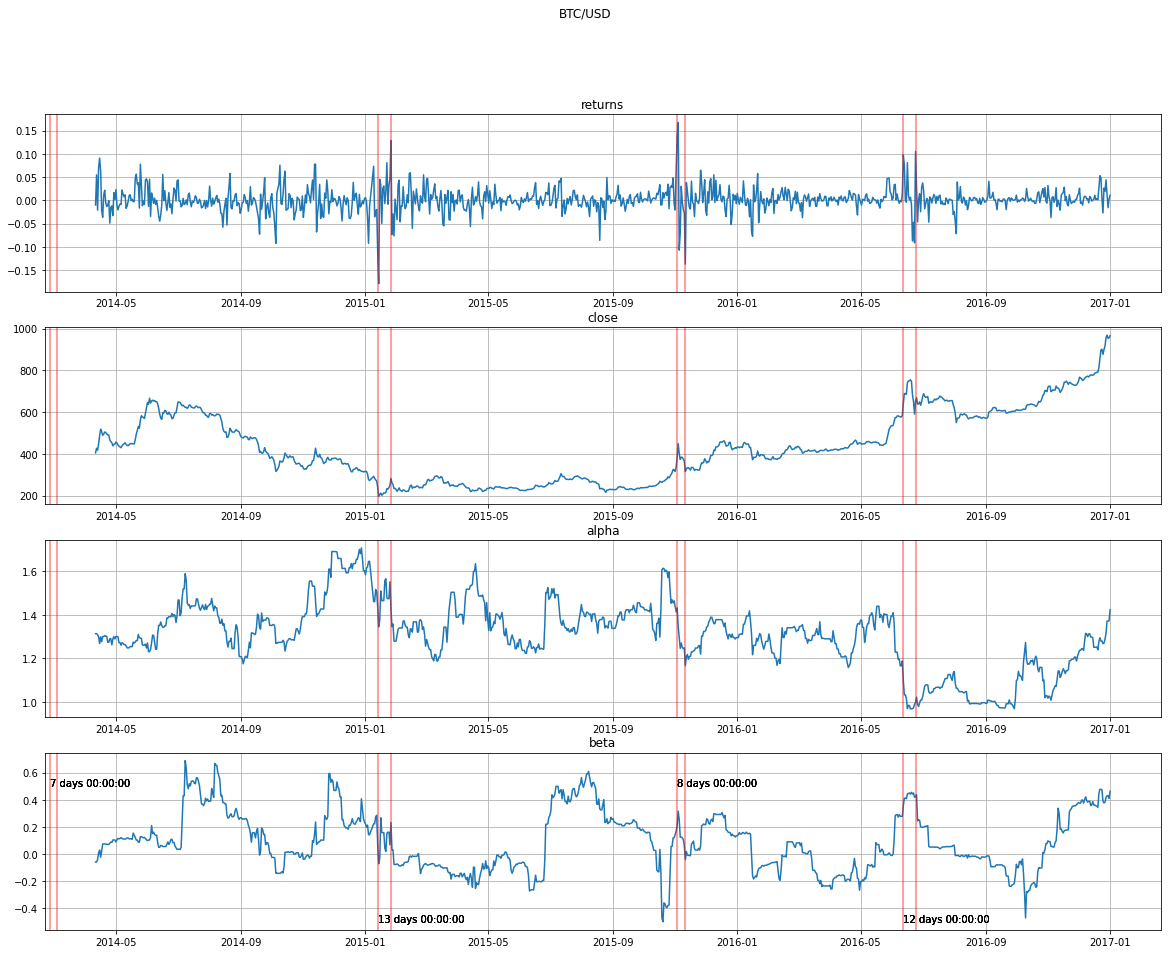

In [5]:
df, shocks = find_shocks(data, std_from_mean=3.5, resample_freq="1d", plot=False, start_date="2014", end_date="2017")
fitted = fit(df, preprocess=False)
plot(fitted, shocks)

FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success
FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success


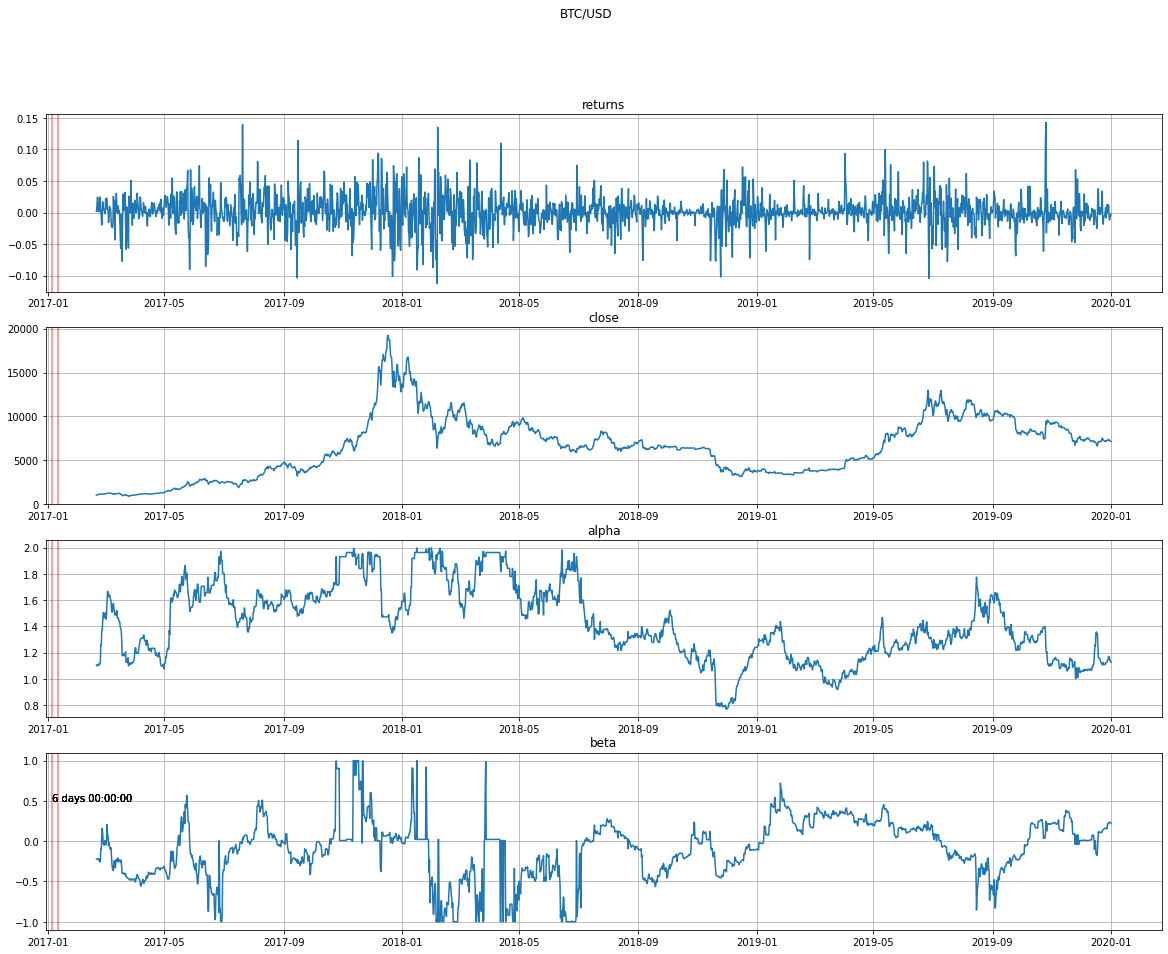

In [8]:
df, shocks = find_shocks(data, std_from_mean=3.5, resample_freq="12h", plot=False, start_date="2017", end_date="2020", min_duration=5)
fitted = fit(df, preprocess=False)
plot(fitted, shocks)

FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success


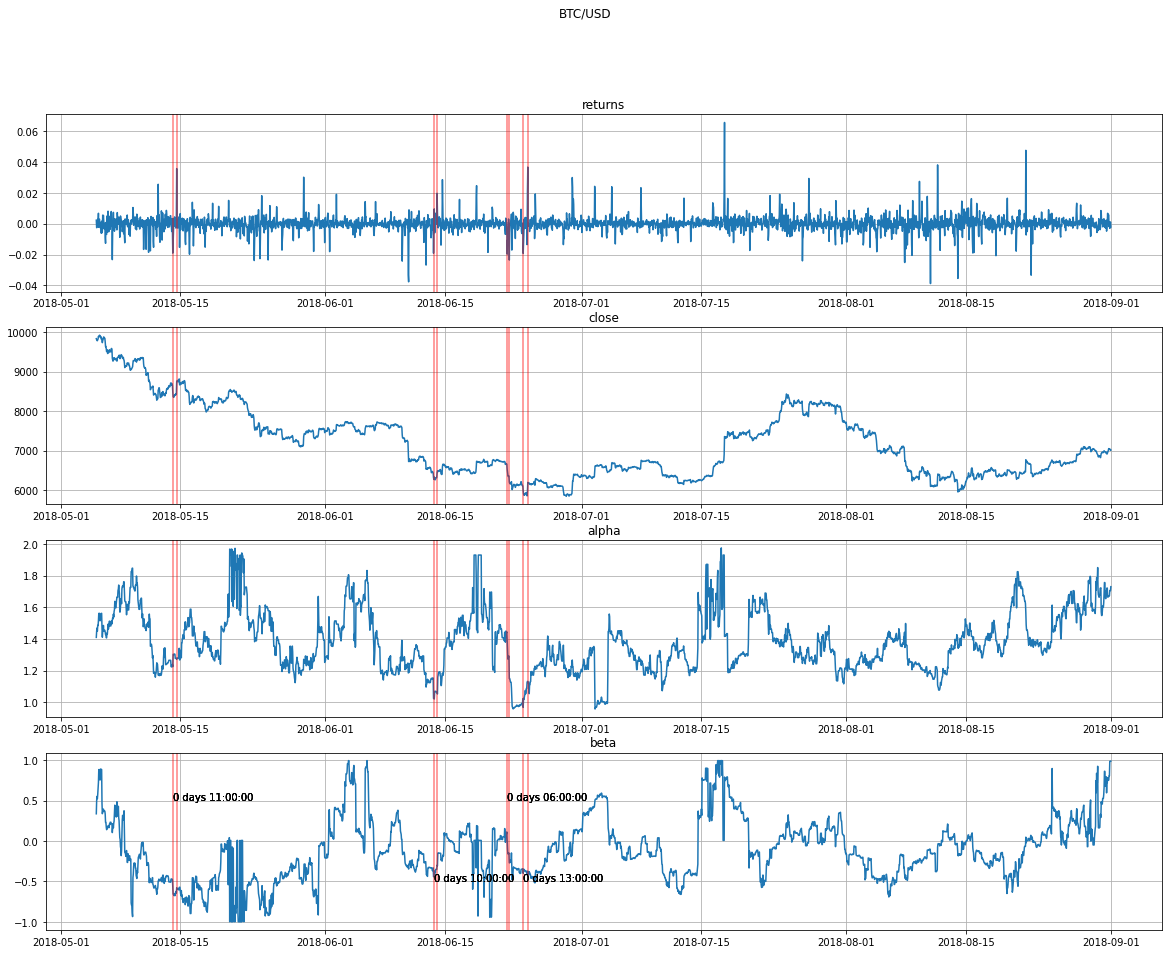

In [9]:
df, shocks = find_shocks(data, std_from_mean=3.5, resample_freq="1h", plot=False, start_date="2018-05", end_date="2018-09")
fitted = fit(df, preprocess=False)
plot(fitted, shocks)

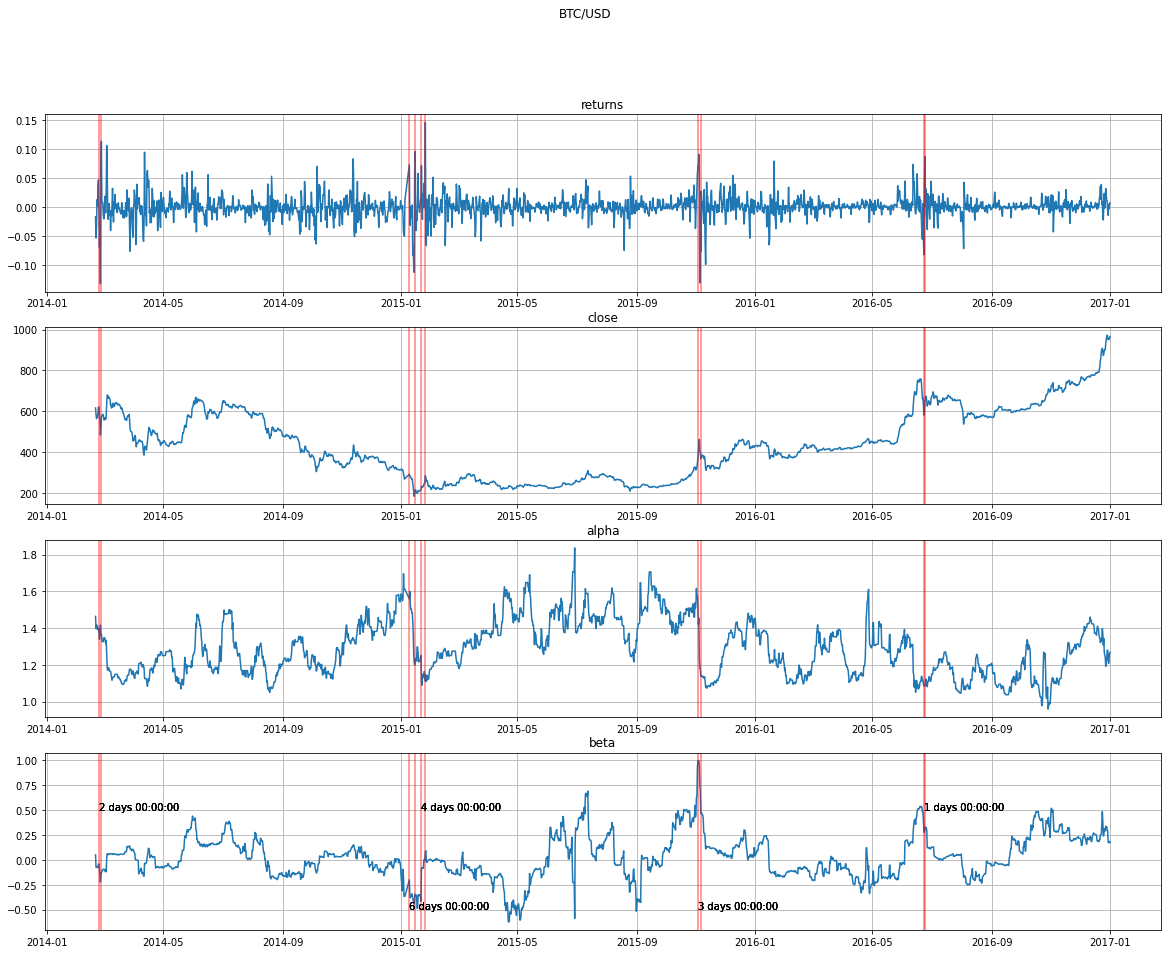

In [10]:
df, shocks = find_shocks(data, std_from_mean=3.5, resample_freq="12h", plot=False)
fitted = fit(df, preprocess=False)
plot(fitted, shocks)

FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success
FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success
FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success


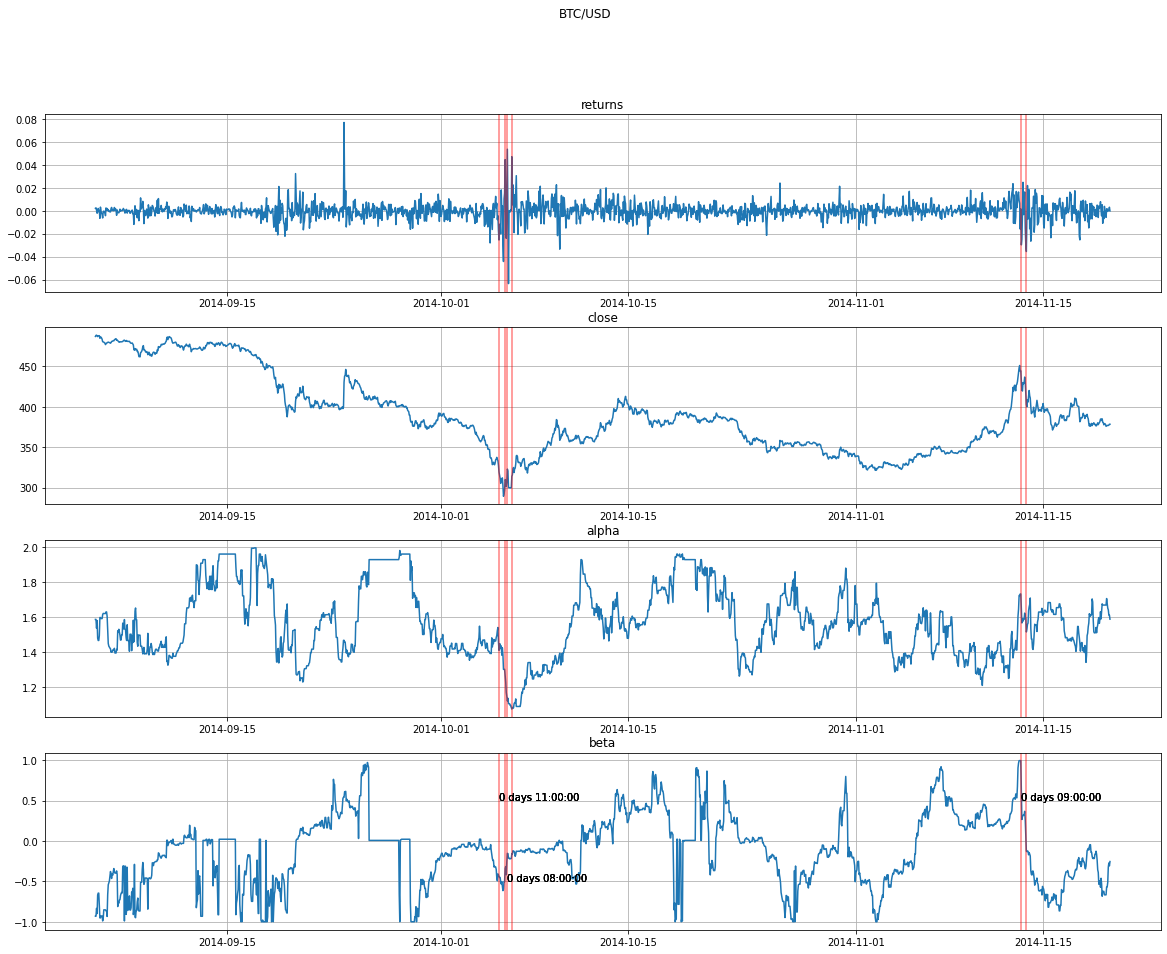

In [11]:
df, shocks = find_shocks(data, std_from_mean=3.5, resample_freq="1h", plot=False, start_date="2014-09-01", end_date="2014-11-20", min_duration=5, max_duration=15)
fitted = fit(df, preprocess=False)
plot(fitted, shocks)

FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success
FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success
FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success
FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success
FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success
FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success
FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success
FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success


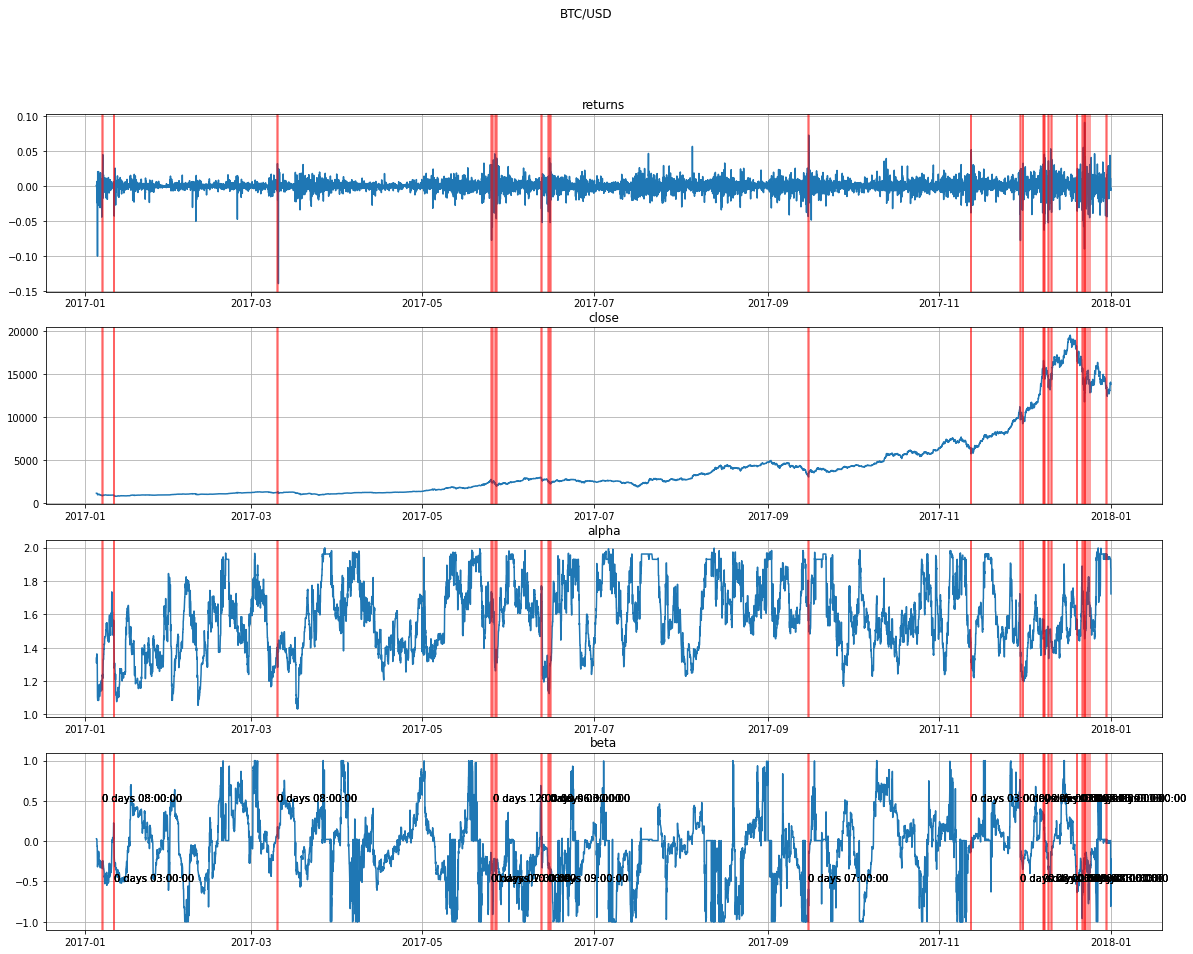

In [12]:
df, shocks = find_shocks(data, std_from_mean=3.5, resample_freq="1h", plot=False, start_date="2017-01", end_date="2018-01")
fitted = fit(df, preprocess=False)
plot(fitted, shocks)

FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success
FINAL ESTIMATED PARAMETER ARE NOT VALID
: Success


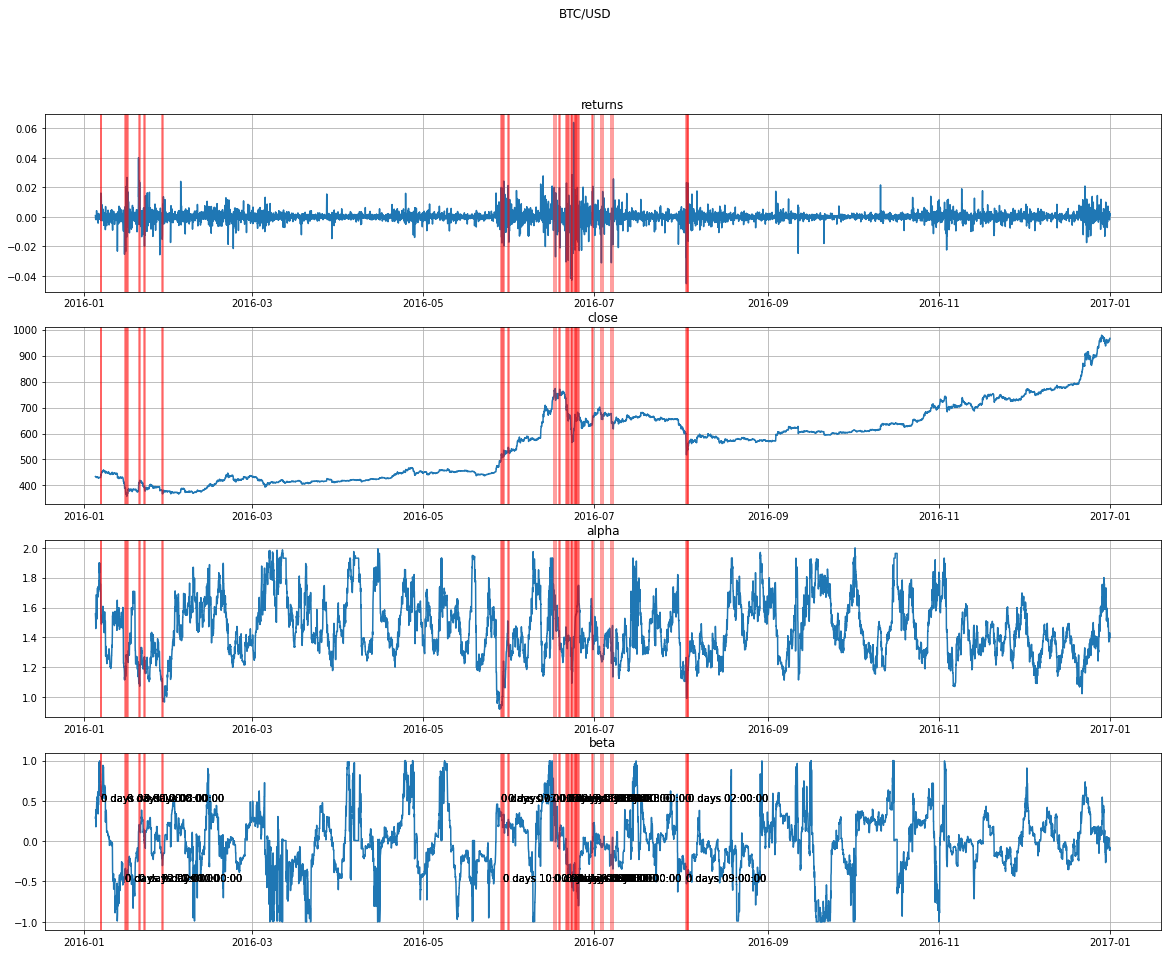

In [13]:
df, shocks = find_shocks(data, std_from_mean=3.5, resample_freq="1h", plot=False, start_date="2016-01", end_date="2017-01")
fitted = fit(df, preprocess=False)
plot(fitted, shocks)

### GOOG

In [44]:
df = pd.DataFrame()
df["close"] =  pdr.data.DataReader("AAPL", 
                    start='2006-1-1', 
                    end='2015-12-31', 
                    data_source='yahoo')['Adj Close']

df["log_returns"] = np.log(df['close']/df['close'].shift(1)).dropna()

init_fit = {'alpha': 2, 'beta': 0, 'sigma': 1, 'mu': 0, 'parameterization': 1}
dist = pystable.create(init_fit['alpha'], init_fit['beta'],
                       init_fit['sigma'], init_fit['mu'],
                       init_fit['parameterization'])

def fit_levy(dist, log_returns, return_param="alpha"):
    pystable.fit(dist, log_returns, len(log_returns))
    if return_param=="alpha":
        return dist.contents.alpha
    if return_param=="beta":
        return dist.contents.beta

df["alpha"] = df["log_returns"].rolling(500).apply(lambda window: fit_levy(dist, window, "alpha")) # 500 days
df["beta"] = df["log_returns"].rolling(500).apply(lambda window: fit_levy(dist, window, "beta"))

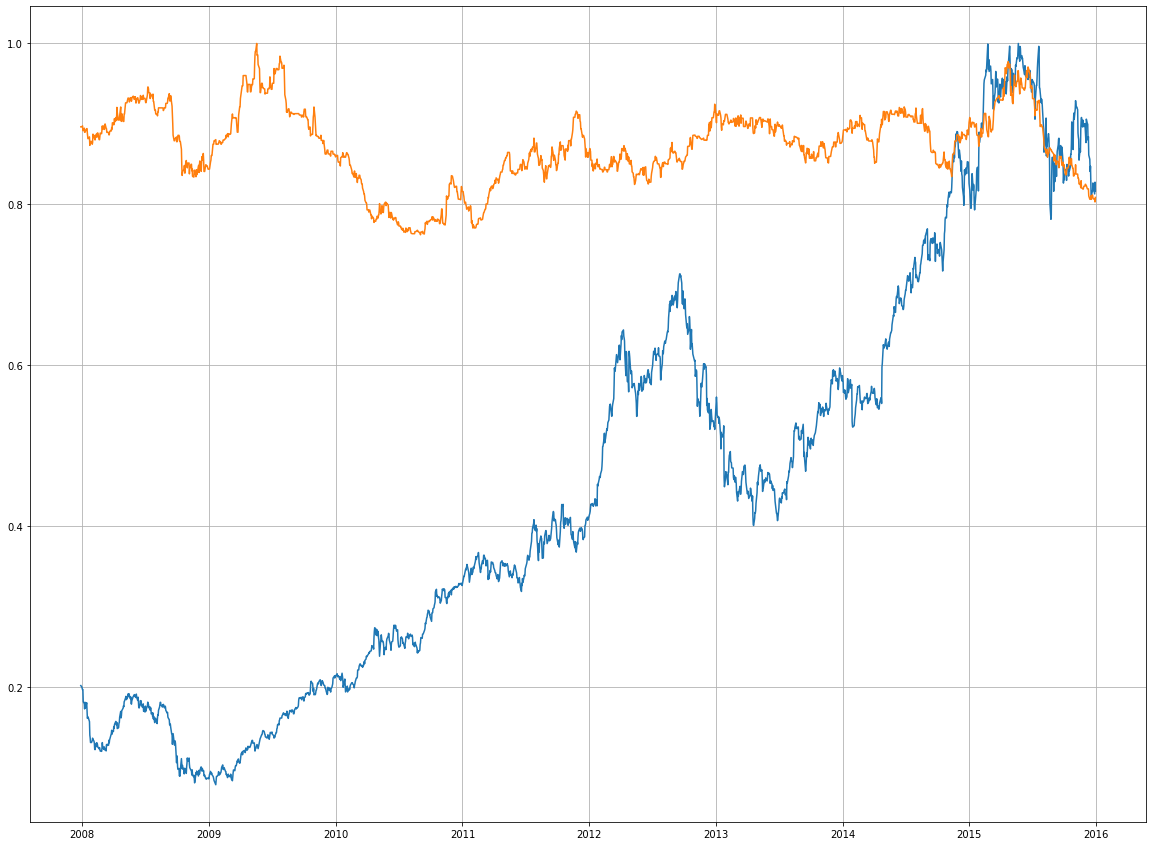

In [49]:
limit = -1

sliced = df.iloc[:limit]
sliced = sliced.dropna()
plt.grid(which="major")
plt.plot(sliced["close"]/sliced["close"].max())
plt.plot(sliced["alpha"]/sliced["alpha"].max())


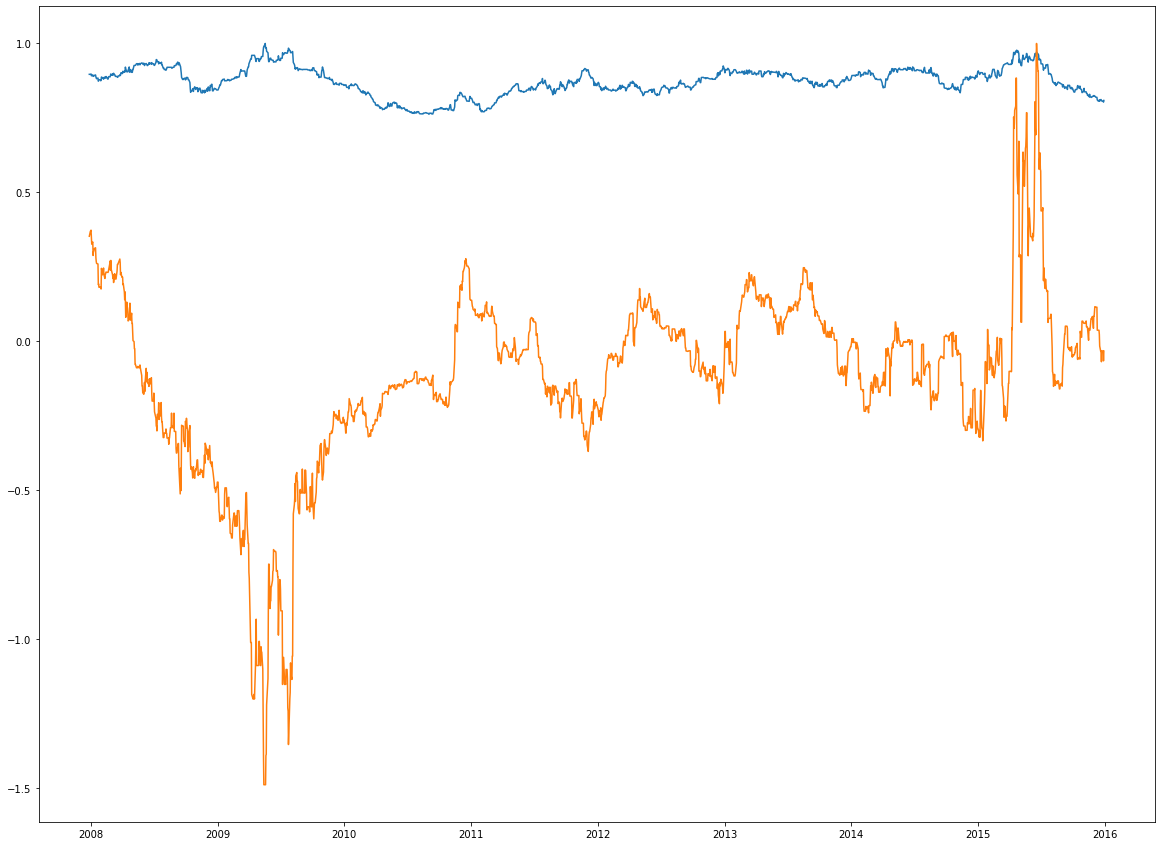

In [54]:
plt.plot(sliced["alpha"]/sliced["alpha"].max())
plt.plot(sliced["beta"]/sliced["beta"].max())

# old

In [50]:
TIME_STEP = 60 # 10080 = 1week, 1440 = 1d

init_fit = {'alpha': 2, 'beta': 0, 'sigma': 1, 'mu': 0,
            'parameterization': 1}
dist = pystable.create(init_fit['alpha'], init_fit['beta'],
                       init_fit['sigma'], init_fit['mu'],
                       init_fit['parameterization'])

time_interval = range(0, len(df), TIME_STEP)
params = []
alpha = []
beta = []

for delta in time_interval:
    pystable.fit(dist, log_returns[delta:delta + TIME_STEP], len(log_returns[delta:delta + TIME_STEP]))
    fit_params = [dist.contents.alpha, dist.contents.beta,
                dist.contents.sigma, dist.contents.mu_0, dist.contents.mu_1]
    
    params.append(fit_params)
    alpha.append(dist.contents.alpha)
    beta.append(dist.contents.beta)

alpha_change = pd.Series(alpha).pct_change().dropna()
beta_change = pd.Series(beta).pct_change().dropna()

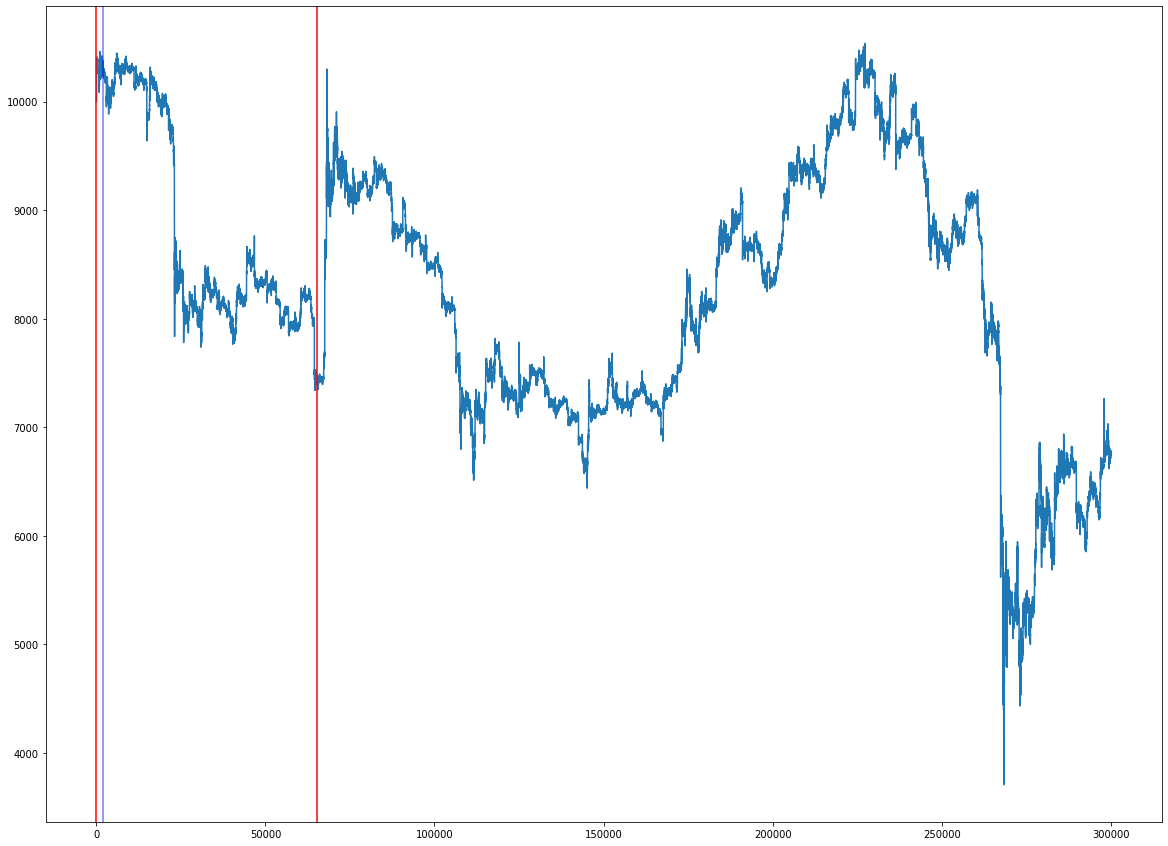

In [51]:


#plt.plot(log_returns)
plt.plot(df["close"].values)
plt.axvline(np.argmax(alpha_change) * TIME_INTERVAL, color="blue", alpha=0.3)
plt.axvline(np.argmin(alpha_change) * TIME_INTERVAL, color="blue", alpha=0.3)

plt.axvline(np.argmax(beta_change) * TIME_INTERVAL, color="red")
plt.axvline(np.argmin(beta_change) * TIME_INTERVAL, color="red")

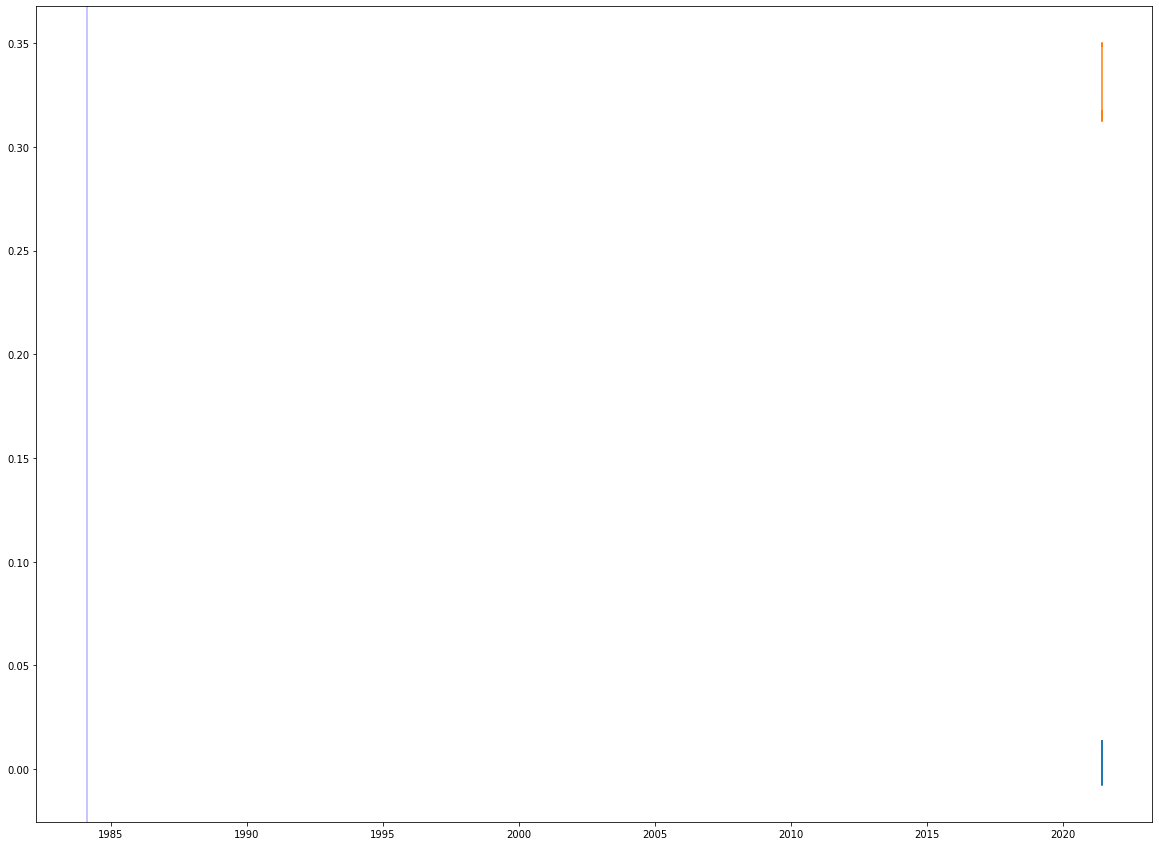

In [34]:
min_ = 4000
max_ = 4900
plt.plot(log_returns[min_ : max_])
plt.plot(df["close"].iloc[min_ : max_])
#plt.axvline(np.argmax(alpha_change) * TIME_INTERVAL, color="blue", alpha=0.3)
plt.axvline(np.argmin(alpha_change) * TIME_INTERVAL, color="blue", alpha=0.3)

#plt.axvline(np.argmax(beta_change) * TIME_INTERVAL, color="red")
#plt.axvline(np.argmin(beta_change) * TIME_INTERVAL, color="red")

In [115]:
np.argmax(alpha_change) * TIME_INTERVAL, np.argmin(alpha_change) * TIME_INTERVAL

(35820, 4800)

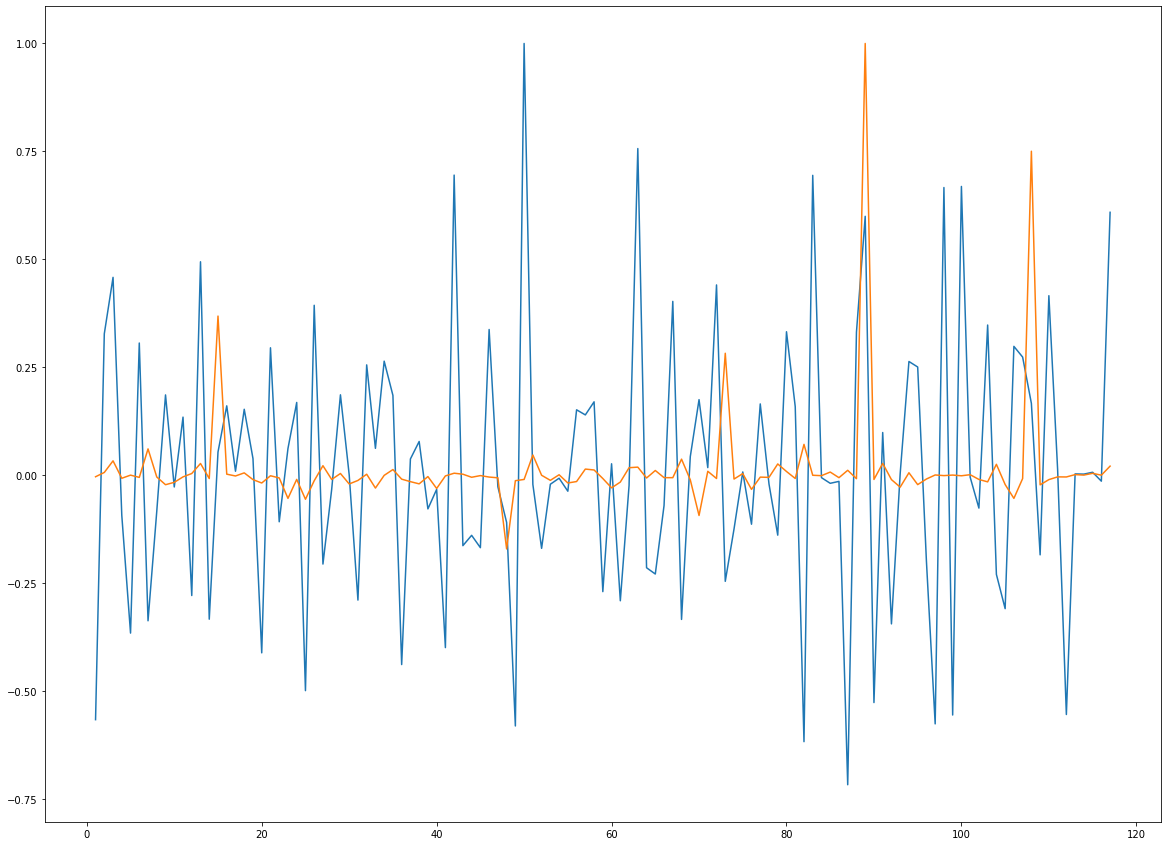

In [36]:
plt.plot(alpha_change/max(alpha_change))
plt.plot(beta_change/max(beta_change))
